In [1]:
import sys

In [2]:
print(sys.executable)

/cvmfs/jupyter.hpc.rwth.de/clients/python311-c23/bin/python


In [3]:
sys.path.append('/home/bh774267/.local/lib/python3.11/site-packages')

In [13]:
import torch
import pennylane as qml

In [14]:
import matplotlib.pyplot as plt

In [15]:
import numpy as np

In [16]:
import torch.nn as nn
import torch.nn.functional as F
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, Subset

In [17]:
#Key Parameters Definition
batch_size_train = 64
batch_size_test = 64
learning_rate = 0.01
momentum = 0 #0 because it's nowhere in our paper
log_interval = 10

random_seed = 1
torch.backends.cudnn.enabled = False
torch.manual_seed(random_seed)

In [18]:
#Data Preparation
import os
import torch.nn as nn
import torchvision
from torchvision import datasets, transforms

In [19]:
transform_mnist=torchvision.transforms.Compose([
                               torchvision.transforms.ToTensor(),
                               torchvision.transforms.Normalize(
                                 (0.5,), (0.5,))
                             ])

trainset_mnist = torchvision.datasets.MNIST(root='./data-mnist', train=True, download=True, transform=transform_mnist)
#train_subset = Subset(trainset_mnist, list(range(10000)))

trainloader_mnist = torch.utils.data.DataLoader(trainset_mnist, batch_size=batch_size_train, shuffle=True)

testset_mnist = torchvision.datasets.MNIST(root='./data-mnist', train=False, download=True, transform=transform_mnist)
#test_subset = Subset(testset_mnist, list(range(200)))
testloader_mnist = torch.utils.data.DataLoader(testset_mnist, batch_size=batch_size_test, shuffle=False)

classes_mnist = ('0','1','2','3','4','5','6','7','8','9')

In [20]:
transform_mnist=torchvision.transforms.Compose([
                               torchvision.transforms.ToTensor(),
                               torchvision.transforms.Normalize(
                                 (0.5,), (0.5,))
                             ])

cnn_trainset_mnist = torchvision.datasets.MNIST(root='./data-mnist', train=True, download=True, transform=transform_mnist)
#train_subset = Subset(trainset_mnist, list(range(10000)))

cnn_trainloader_mnist = torch.utils.data.DataLoader(cnn_trainset_mnist, batch_size=batch_size_train, shuffle=True)

cnn_testset_mnist = torchvision.datasets.MNIST(root='./data-mnist', train=False, download=True, transform=transform_mnist)
#test_subset = Subset(testset_mnist, list(range(200)))
cnn_testloader_mnist = torch.utils.data.DataLoader(cnn_testset_mnist, batch_size=batch_size_test, shuffle=False)

classes_mnist = ('0','1','2','3','4','5','6','7','8','9')

In [13]:
#CNN Model
class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        self.conv_layer = nn.Sequential(
            nn.Conv2d(1, 32, kernel_size=3, padding=1),  # [1,28,28] -> [32,28,28]
            nn.ReLU(),
            nn.MaxPool2d(2),                             # -> [32,14,14]
            nn.Conv2d(32, 64, kernel_size=3, padding=1), # -> [64,14,14]
            nn.ReLU(),
            nn.MaxPool2d(2)                              # -> [64,7,7]
        )
        self.fc_layer = nn.Sequential(
            nn.Flatten(),
            nn.Linear(64 * 7 * 7, 128),
            nn.ReLU(),
            nn.Linear(128, 10)  # 10 classes
        )

    def forward(self, x):
        x = self.conv_layer(x)
        x = self.fc_layer(x)
        return x

In [15]:
#CNN Training
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
os.environ["KMP_DUPLICATE_LIB_OK"] = "TRUE"

model = CNN().to(device)
#Loss Function and Optimizer
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

#Training of the Model
cnn_loss_values = [] # <-- store loss per epoch
cnn_accuracy = [] # store accuracy per epoch
n_epochs = 20
#Evaluation on Test Dataset
def cnn_test(model):
    model.eval()
    correct = 0
    total = 0

    with torch.no_grad():
        for images, labels in cnn_testloader_mnist:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
        accuracy = correct / len(cnn_testloader_mnist.dataset) * 100
        cnn_accuracy.append(accuracy)
        print(f"Test Accuracy: {accuracy:.2f}%")


for epoch in range(n_epochs):
    model.train()
    running_loss = 0.0
    for images, labels in cnn_trainloader_mnist:
        images, labels = images.to(device), labels.to(device)

        outputs = model(images)
        loss = criterion(outputs, labels)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        running_loss += loss.item()

    avg_loss = running_loss / len(cnn_trainloader_mnist)
    cnn_loss_values.append(avg_loss)  # <-- save this epoch's average loss
    print(f"CNN Epoch [{epoch+1}/{n_epochs}], CNN Loss: {avg_loss:.4f}")
    cnn_test(model)

CNN Epoch [1/20], CNN Loss: 0.2117
Test Accuracy: 96.99%
CNN Epoch [2/20], CNN Loss: 0.1034
Test Accuracy: 97.06%
CNN Epoch [3/20], CNN Loss: 0.0924
Test Accuracy: 97.27%
CNN Epoch [4/20], CNN Loss: 0.0862
Test Accuracy: 97.08%
CNN Epoch [5/20], CNN Loss: 0.0810
Test Accuracy: 97.61%
CNN Epoch [6/20], CNN Loss: 0.0773
Test Accuracy: 97.65%
CNN Epoch [7/20], CNN Loss: 0.0793
Test Accuracy: 97.85%
CNN Epoch [8/20], CNN Loss: 0.0786
Test Accuracy: 97.38%
CNN Epoch [9/20], CNN Loss: 0.0728
Test Accuracy: 97.40%
CNN Epoch [10/20], CNN Loss: 0.0740
Test Accuracy: 97.48%
CNN Epoch [11/20], CNN Loss: 0.0701
Test Accuracy: 97.70%
CNN Epoch [12/20], CNN Loss: 0.0714
Test Accuracy: 97.64%
CNN Epoch [13/20], CNN Loss: 0.0698
Test Accuracy: 97.46%
CNN Epoch [14/20], CNN Loss: 0.0658
Test Accuracy: 97.76%
CNN Epoch [15/20], CNN Loss: 0.0653
Test Accuracy: 98.08%
CNN Epoch [16/20], CNN Loss: 0.0654
Test Accuracy: 97.54%
CNN Epoch [17/20], CNN Loss: 0.0662
Test Accuracy: 97.54%
CNN Epoch [18/20], CNN 

NameError: name 'cnn_loss_values' is not defined

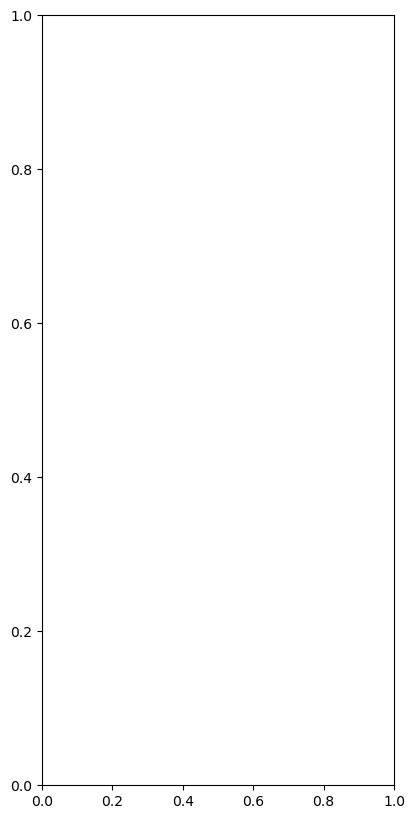

In [30]:
# Plot training loss
plt.figure(figsize=(10, 10))

plt.subplot(1, 2, 1)
#plt.plot(train_losses, marker='o', label='QCNN Training Loss', color='blue')
plt.plot(cnn_loss_values,marker='s', label='CNN Training Loss', color='red')
plt.title('Training Loss per Epoch')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.grid(True)
plt.legend()

# Plot test accuracy
plt.subplot(1, 2, 2)
#plt.plot(test_accuracies, marker= 'o', label='QCNN Accuracy', color= 'blue')
plt.plot(cnn_accuracy,marker= 's', label= 'CNN Accuracy', color= 'red')
plt.title('Test Accuracy per Epoch')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.grid(True)
plt.legend()

plt.tight_layout()
plt.savefig('mnist_cnn.png')
plt.show()

In [21]:
import pennylane as qml
import os
from pennylane import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, Subset
from torch.func import vmap

In [22]:
#AutoEncoder Class

class Encoder(nn.Module):
    def __init__(self):
        super(Encoder, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, kernel_size=3, stride=1, padding=1)
        self.pool = nn.MaxPool2d(2, 2)  # reduces spatial dims by half
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1)
        self.fc1 = nn.Linear(64 * 7 * 7, 128)
        self.fc2 = nn.Linear(128, 4)

    def forward(self, x):
        x = torch.relu(self.conv1(x))  # shape: (batch, 32, 28, 28)
        x = self.pool(x)               # shape: (batch, 32, 14, 14)
        x = torch.relu(self.conv2(x))  # shape: (batch, 64, 14, 14)
        x = self.pool(x)               # shape: (batch, 64, 7, 7)
        x = torch.flatten(x, start_dim=1)  # flatten to (batch, 64*7*7)
        x = torch.relu(self.fc1(x))
        x = self.fc2(x)
        return x



class Decoder(nn.Module):
    def __init__(self):
        super(Decoder, self).__init__()
        self.fc1 = nn.Linear(4, 128)
        self.fc2 = nn.Linear(128, 64 * 7 * 7)
        self.deconv1 = nn.ConvTranspose2d(64, 32, kernel_size=3, stride=1, padding=1)
        self.deconv2 = nn.ConvTranspose2d(32, 1, kernel_size=3, stride=1, padding=1)

    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        x = x.view(-1, 64, 7, 7)
        x = torch.relu(self.deconv1(x))
        x = torch.sigmoid(self.deconv2(x))
        return x

"""
class Autoencoder(nn.Module):
    def __init__(self):
        super(Autoencoder, self).__init__()

        # Encoder
        self.encoder = nn.Sequential(
            nn.Linear(28*28, 128),
            nn.ReLU(),
            nn.Linear(128, 64),
            nn.ReLU(),
            nn.Linear(64, 12),
            nn.ReLU(),
            nn.Linear(12,4)   # Compressed (4 dimensions)
        )
        self.decoder = nn.Sequential(
            nn.Linear(4, 12),
            nn.ReLU(),
            nn.Linear(12, 64),
            nn.ReLU(),
            nn.Linear(64, 128),
            nn.ReLU(),
            nn.Linear(128, 28 * 28),
            nn.Sigmoid()
        )
    def forward(self, x):
        #x = x.view(-1, 28*28)   # Flatten image
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return decoded

"""

'\nclass Autoencoder(nn.Module):\n    def __init__(self):\n        super(Autoencoder, self).__init__()\n\n        # Encoder\n        self.encoder = nn.Sequential(\n            nn.Linear(28*28, 128),\n            nn.ReLU(),\n            nn.Linear(128, 64),\n            nn.ReLU(),\n            nn.Linear(64, 12),\n            nn.ReLU(),\n            nn.Linear(12,4)   # Compressed (4 dimensions)\n        )\n        self.decoder = nn.Sequential(\n            nn.Linear(4, 12),\n            nn.ReLU(),\n            nn.Linear(12, 64),\n            nn.ReLU(),\n            nn.Linear(64, 128),\n            nn.ReLU(),\n            nn.Linear(128, 28 * 28),\n            nn.Sigmoid()\n        )\n    def forward(self, x):\n        #x = x.view(-1, 28*28)   # Flatten image\n        encoded = self.encoder(x)\n        decoded = self.decoder(encoded)\n        return decoded\n\n'

In [23]:
#Quantum Device settings
n_qubits = 4
dev = qml.device("default.qubit", wires=n_qubits)

In [24]:
# QCNN layer
def qcnn_block(weights,wires=4):
    for w in range(wires):
        qml.Hadamard(w)
    # Convolution Layer 1
    qml.CNOT(wires=[0, 1])
    qml.RY(weights[0], wires=1)
    qml.CNOT(wires=[2, 3])
    qml.RY(weights[1], wires=3)
    #qml.CNOT(wires=[4, 5])
    #qml.RY(weights[3], wires=5)
    #qml.CNOT(wires=[6, 7])
    #qml.RY(weights[5], wires=7)
    #qml.CNOT(wires=[8, 9])
    #qml.RY(weights[7], wires=9)
    
    # Pooling Layer 1
    qml.CNOT(wires=[1, 0])
    qml.RY(weights[1], wires=0)  # keep 0, discard 1
    qml.CNOT(wires=[3, 2])
    qml.RY(weights[3], wires=2)  # keep 2, discard 3
    #qml.CNOT(wires=[5, 4])
    #qml.RY(weights[5], wires=4)  # keep 4, discard 5
    #qml.CNOT(wires=[7, 6])
    #qml.RY(weights[7], wires=6)  # keep 6, discard 7
    #qml.CNOT(wires=[9, 8])
    #qml.RY(weights[9], wires=8)  # keep 8, discard 9
    
    # Convolution Layer 2
    qml.CNOT(wires=[0, 2])
    qml.RY(weights[3], wires=2)
    qml.CNOT(wires=[1, 3])
    qml.RY(weights[1], wires=3)
    #qml.CNOT(wires=[4, 6])
    #qml.RY(weights[4], wires=6)
    #qml.CNOT(wires=[6, 8])
    #qml.RY(weights[4], wires=8)

    # Convolution Layer 3 (Final Layer)
    #qml.CNOT(wires=[2, 0])
    #qml.RY(weights[5], wires=0)
    #qml.CNOT(wires=[4, 2])
    #qml.RY(weights[5], wires=2)

In [25]:
@qml.qnode(dev, interface="torch")
def quantum_circuit(inputs, weights):
    # Angle encoding
    qml.templates.AngleEmbedding(inputs, wires=range(4), rotation='Y')
    # Amplitude encoding
    #qml.templates.AmplitudeEmbedding(inputs, wires=range(2), normalize=True)
    qcnn_block(weights)
    #print(qml.draw(qcnn_block)(weights)
    return [qml.expval(qml.PauliZ(i)) for i in [0,1,2,3]]

In [26]:
weight_shapes = {"weights": (4,)}
qcnn_layer = qml.qnn.TorchLayer(quantum_circuit, weight_shapes)

class QuantumLayer(nn.Module):
    def __init__(self):
        super().__init__()
        self.qlayer = qml.qnn.TorchLayer(quantum_circuit, weight_shapes)
        nn.init.uniform_(self.qlayer.qnode_weights["weights"], -0.1, 0.1)

    def forward(self, x):
        return vmap(self.qlayer)(x)

#QCNN MOdel Class
"""
class QCNN(nn.Module):
    def __init__(self):
        super().__init__()
        self.fc1 = nn.Linear(28 * 28, 8)  # Reduce MNIST image to 8 features
        self.qcnn = qcnn_layer
        self.fc2 = nn.Linear(8, 10)       # Output layer for 10 classes

    def forward(self, x):
        x = x.view(-1, 28 * 28)
        x = torch.tanh(self.fc1(x))
        # Use vmap to apply the quantum layer to the batch
        x = self.qcnn(x)  # [batch_size, 2]
        x = self.fc2(x)
        return F.log_softmax(x, dim=1)
"""

#QCNN and AutoEncoder Hybrid Model
class HybridModel(nn.Module):
    def __init__(self):
        super().__init__()
        self.encoder = Encoder()
        self.quantum = qcnn_layer
        self.decoder = Decoder()
        self.fc_out = nn.Linear(4, 10)  # Output logits for 10 MNIST classes

    
    def forward(self, x):
        latent = self.encoder(x)                      # Compress image to latent space
        quantum_out = self.quantum(latent)            # Quantum processing
        recons_image = self.decoder(quantum_out)      # reconstruction of image
        class_logits = self.fc_out(quantum_out)   # Final classification layer
                           
        return recons_image, F.log_softmax(class_logits, dim=1)

In [27]:
import matplotlib.pyplot as plt
import torch

def show_reconstruction(original, reconstructed, n=6):
    """
    Display n original and reconstructed images side-by-side.
    - original: tensor of shape (batch_size, 1, 28, 28)
    - reconstructed: tensor of shape (batch_size, 1, 28, 28)
    """
    original = original.detach().cpu()
    reconstructed = reconstructed.detach().cpu()

    plt.figure(figsize=(12, 4))
    for i in range(n):
        # Original image
        plt.subplot(2, n, i + 1)
        plt.imshow(original[i].squeeze(), cmap='gray')
        plt.title("Original")
        plt.axis('off')

        # Reconstructed image
        plt.subplot(2, n, n + i + 1)
        plt.imshow(reconstructed[i].squeeze(), cmap='gray')
        plt.title("Reconstructed")
        plt.axis('off')

    plt.tight_layout()
    plt.show()


Complexity

<function specs.<locals>.specs_qnode at 0x153354231080>


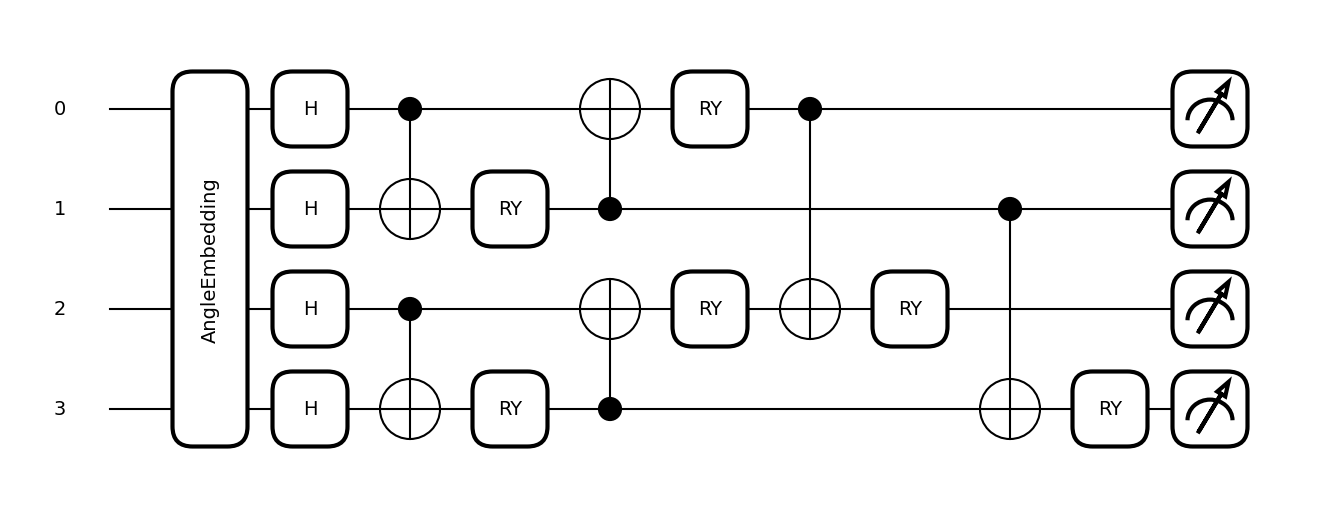

In [28]:
model = HybridModel()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
loss_fn = nn.CrossEntropyLoss()
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

"""
modelAE = Encoder()
optimizer = torch.optim.Adam(modelAE.parameters(), lr=0.001)
loss_function = nn.MSELoss()
#device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
modelAE.to(device)
"""
dummy_inputs = np.linspace(0, np.pi, 4)
dummy_weights = np.linspace(0, np.pi / 2, 4)

drawer = qml.draw_mpl(quantum_circuit)
fig, ax = drawer(dummy_inputs, dummy_weights)

# Save to file
fig.savefig("quantum_circuit_AutoEncoder_Hadamard.png", dpi=300, bbox_inches='tight')

specs = qml.specs(quantum_circuit)
print("Complexity\n")
print(specs)


def evaluate(model, testloader_mnist, loss_fn, device):
    model.eval()
    total_loss = 0
    correct = 0
    total = 0

    with torch.no_grad():
        for images, labels in testloader_mnist:
            images, labels = images.to(device), labels.to(device)
            
            outputs = model(images)
            recons, class_logits = outputs
            loss = loss_fn(class_logits, labels)
            total_loss += loss.item()

            _, predicted = torch.max(class_logits.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    avg_loss = total_loss / len(testloader_mnist)
    accuracy = correct / total
    return avg_loss, accuracy

In [29]:
val_loss_list = []
val_accuracy_list = []

loss_list = []
accuracy_list = []

num_epochs = 10

for epoch in range(num_epochs):
    model.train()
    correct = 0
    total = 0
    total_loss = 0

    for images, labels in trainloader_mnist:
        images, labels = images.to(device), labels.to(device)
        optimizer.zero_grad()

        outputs = model(images)
        recons, class_logits = outputs
        loss = loss_fn(class_logits, labels)
        #loss = loss_fn(outputs, labels)
        loss.backward()
        optimizer.step()

        total_loss += loss.item()

        _, predicted = torch.max(class_logits.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

    epoch_loss = total_loss / len(trainloader_mnist)
    epoch_accuracy = correct / total
    
    loss_list.append(epoch_loss)
    accuracy_list.append(epoch_accuracy*100)

    val_loss, val_accuracy = evaluate(model, testloader_mnist, loss_fn, device)
    val_loss_list.append(val_loss)
    val_accuracy_list.append(val_accuracy*100)

    print(f"Epoch {epoch+1}: "
          f"Train Loss = {epoch_loss:.4f}, Train Acc = {epoch_accuracy:.4f} | "
          f"Test Loss = {val_loss:.4f}, Test Acc = {val_accuracy:.4f}")


Epoch 1: Train Loss = 1.0939, Train Acc = 0.8284 | Test Loss = 0.5392, Test Acc = 0.9695
Epoch 2: Train Loss = 0.3453, Train Acc = 0.9771 | Test Loss = 0.2337, Test Acc = 0.9819
Epoch 3: Train Loss = 0.1728, Train Acc = 0.9859 | Test Loss = 0.1429, Test Acc = 0.9831
Epoch 4: Train Loss = 0.1042, Train Acc = 0.9908 | Test Loss = 0.1051, Test Acc = 0.9859
Epoch 5: Train Loss = 0.0669, Train Acc = 0.9934 | Test Loss = 0.0793, Test Acc = 0.9878
Epoch 6: Train Loss = 0.0456, Train Acc = 0.9954 | Test Loss = 0.0721, Test Acc = 0.9871
Epoch 7: Train Loss = 0.0333, Train Acc = 0.9961 | Test Loss = 0.0656, Test Acc = 0.9873
Epoch 8: Train Loss = 0.0237, Train Acc = 0.9970 | Test Loss = 0.0759, Test Acc = 0.9830
Epoch 9: Train Loss = 0.0177, Train Acc = 0.9979 | Test Loss = 0.0617, Test Acc = 0.9871
Epoch 10: Train Loss = 0.0148, Train Acc = 0.9980 | Test Loss = 0.0529, Test Acc = 0.9881


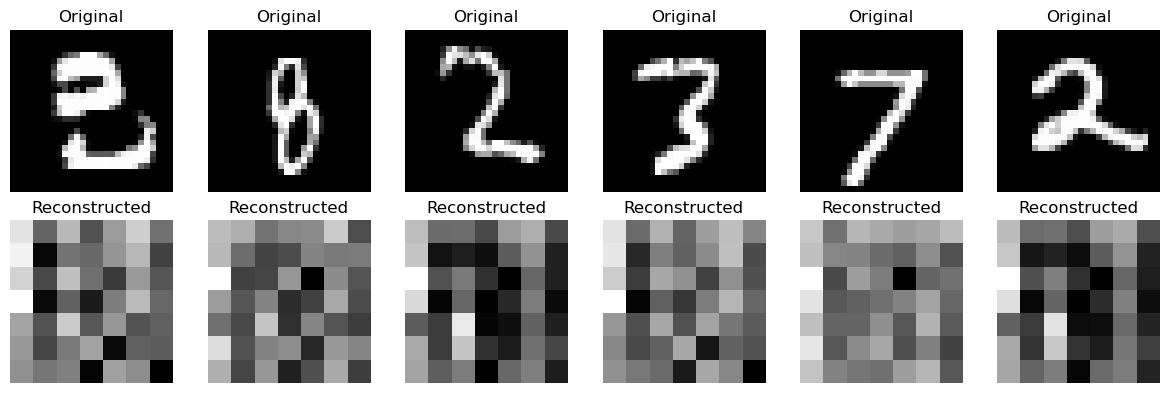

In [30]:
model.eval()
with torch.no_grad():
    images, labels = next(iter(trainloader_mnist))         # get a batch of images
    images = images.to(device)                      # move to GPU if applicable

    recons, _ = model(images)                # run through model

    show_reconstruction(images, recons, n=6)  # visualize 6 examples

In [ ]:
dataiter = iter(testloader_mnist)
images, _ = next(dataiter)

images = images.view(-1, 28 * 28).to(device)
reconstructed = model(images)

fig, axes = plt.subplots(nrows=2, ncols=10, figsize=(10, 3))
for i in range(10):
    axes[0, i].imshow(images[i].cpu().detach().numpy().reshape(28, 28), cmap='gray')
    axes[0, i].axis('off')
    axes[1, i].imshow(reconstructed[i].cpu().detach().numpy().reshape(28, 28), cmap='gray')
    axes[1, i].axis('off')
plt.show()

Epoch 1/20, Loss: 0.928101
Epoch 2/20, Loss: 0.927343
Epoch 3/20, Loss: 0.923733
Epoch 4/20, Loss: 0.922303
Epoch 5/20, Loss: 0.921731
Epoch 6/20, Loss: 0.918223
Epoch 7/20, Loss: 0.933054
Epoch 8/20, Loss: 0.925026
Epoch 9/20, Loss: 0.925670
Epoch 10/20, Loss: 0.927034
Epoch 11/20, Loss: 0.923233
Epoch 12/20, Loss: 0.924262
Epoch 13/20, Loss: 0.920448
Epoch 14/20, Loss: 0.921018
Epoch 15/20, Loss: 0.924807
Epoch 16/20, Loss: 0.926080
Epoch 17/20, Loss: 0.920415
Epoch 18/20, Loss: 0.924734
Epoch 19/20, Loss: 0.925292
Epoch 20/20, Loss: 0.924495


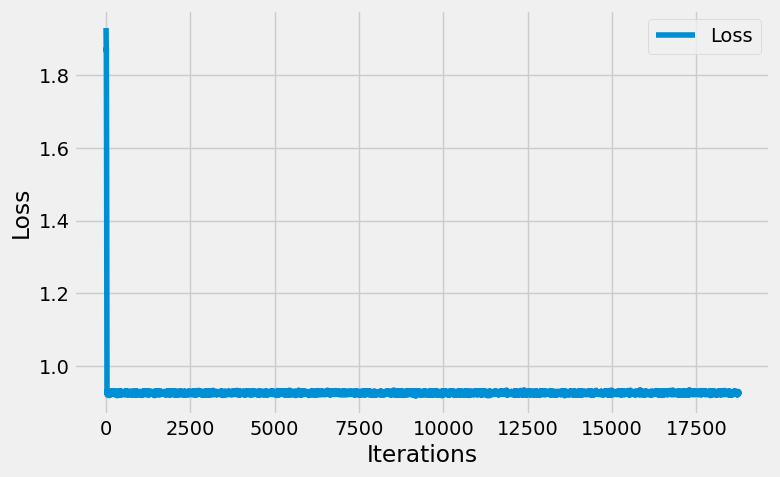

In [57]:
epochs = 20
outputs = []
losses = []


for epoch in range(epochs):
    for images, _ in trainloader_mnist:
        images = images.view(-1, 28 * 28).to(device)
        
        reconstructed = modelAE(images)
        loss = loss_function(reconstructed, images)
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        losses.append(loss.item())
    
    outputs.append((epoch, images, reconstructed))
    print(f"Epoch {epoch+1}/{epochs}, Loss: {loss.item():.6f}")

plt.style.use('fivethirtyeight')
plt.figure(figsize=(8, 5))
plt.plot(losses, label='Loss')
plt.xlabel('Iterations')
plt.ylabel('Loss')
plt.legend()
plt.show()

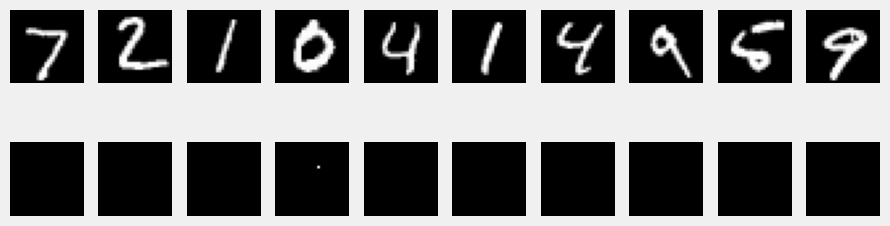

In [59]:
modelAE.eval()
dataiter = iter(testloader_mnist)
images, _ = next(dataiter)

images = images.view(-1, 28 * 28).to(device)
reconstructed = modelAE(images)

fig, axes = plt.subplots(nrows=2, ncols=10, figsize=(10, 3))
for i in range(10):
    axes[0, i].imshow(images[i].cpu().detach().numpy().reshape(28, 28), cmap='gray')
    axes[0, i].axis('off')
    axes[1, i].imshow(reconstructed[i].cpu().detach().numpy().reshape(28, 28), cmap='gray')
    axes[1, i].axis('off')
plt.show()

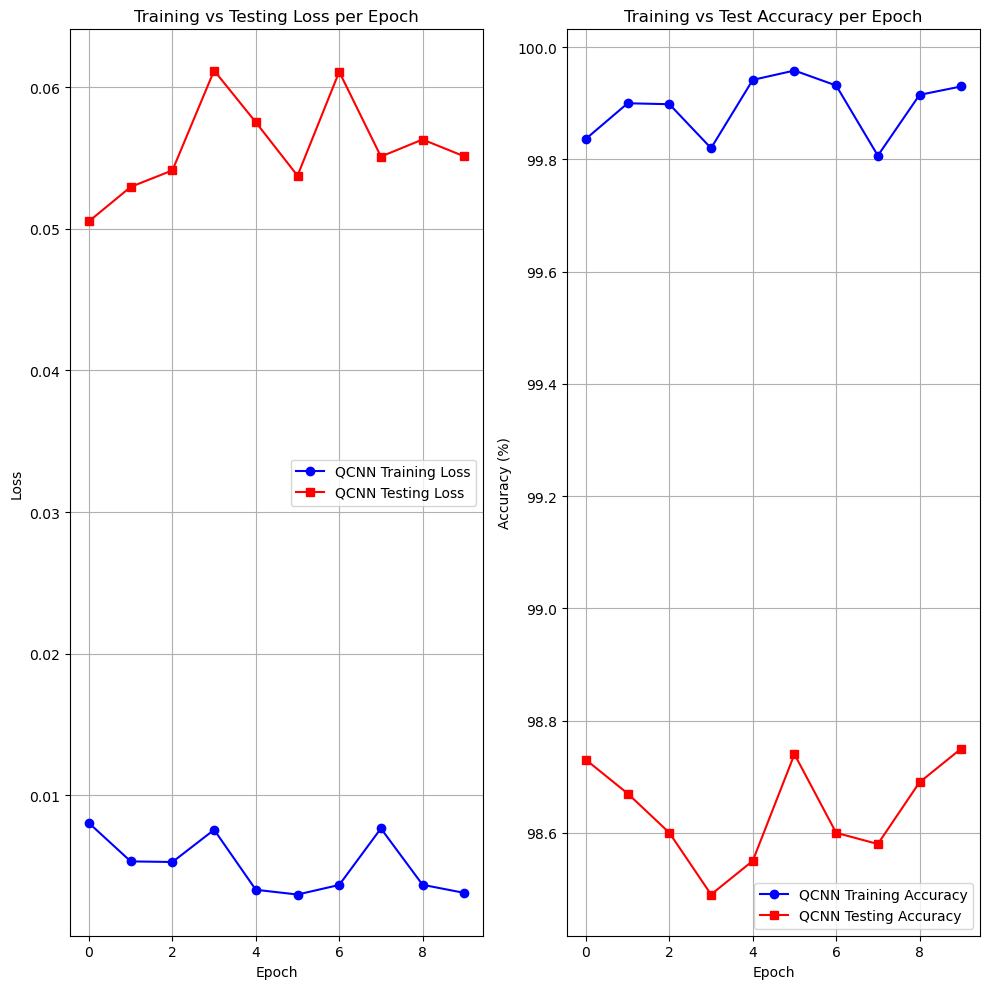

In [31]:

    # Plot training loss
    plt.figure(figsize=(10, 10))
    
    plt.subplot(1, 2, 1)
    plt.plot(loss_list, marker='o', label='QCNN Training Loss', color='blue')
    plt.plot(val_loss_list,marker='s', label='QCNN Testing Loss', color='red')
    plt.title('Training vs Testing Loss per Epoch')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.grid(True)
    plt.legend()
    
    # Plot test accuracy
    plt.subplot(1, 2, 2)
    plt.plot(accuracy_list, marker= 'o', label='QCNN Training Accuracy', color= 'blue')
    plt.plot(val_accuracy_list,marker= 's', label= 'QCNN Testing Accuracy', color= 'red')
    plt.title('Training vs Test Accuracy per Epoch')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy (%)')
    plt.grid(True)
    plt.legend()
    
    plt.tight_layout()
    plt.savefig('mnist_qcnn_w_CONVAE_4.png')
    plt.show()

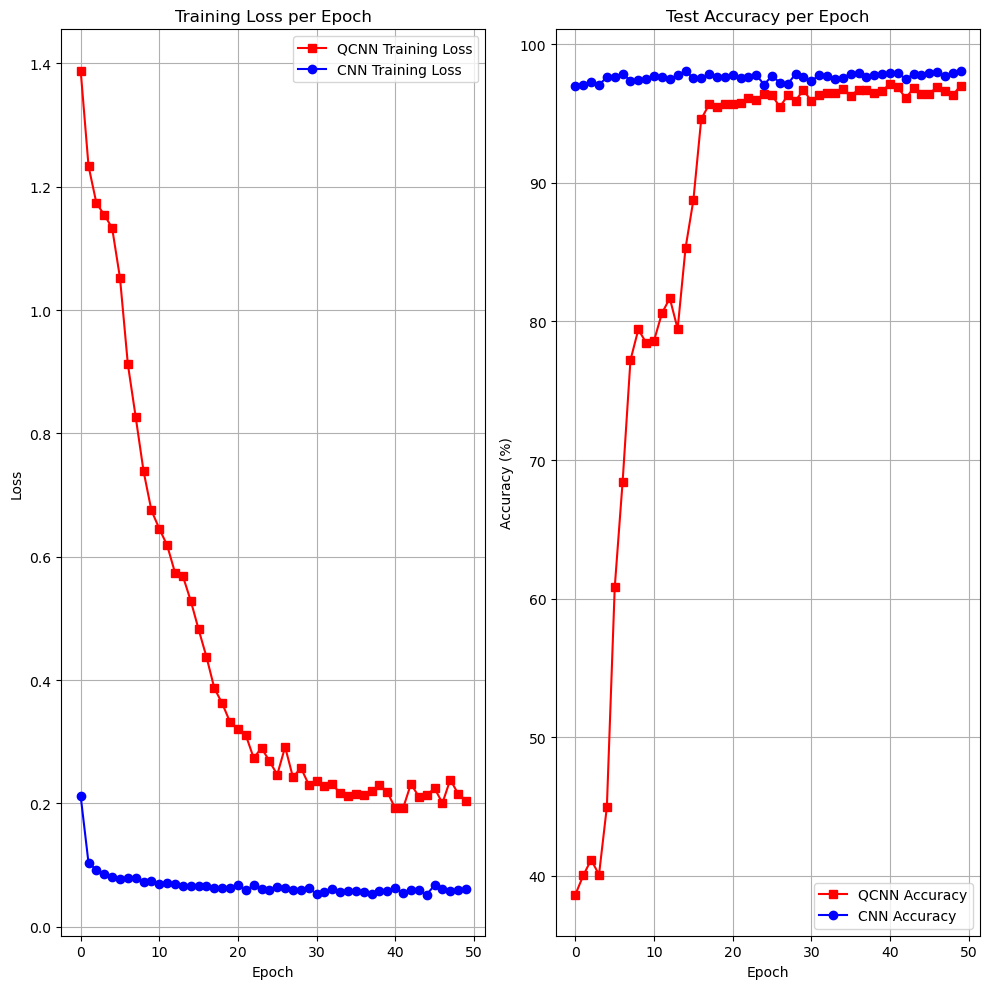

In [39]:
# Plot training loss
plt.figure(figsize=(10, 10))
    
plt.subplot(1, 2, 1)
#plt.plot(train_losses, marker='o', label='QCNN Training Loss', color='blue')
plt.plot(val_loss_list,marker='s', label='QCNN Training Loss', color='red')
plt.plot(cnn_loss_values,marker='o', label='CNN Training Loss', color='blue')
plt.title('Training Loss per Epoch')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.grid(True)
plt.legend()
    
# Plot test accuracy
plt.subplot(1, 2, 2)
#plt.plot(test_accuracies, marker= 'o', label='QCNN Accuracy', color= 'blue')
plt.plot(val_accuracy_list,marker= 's', label= 'QCNN Accuracy', color= 'red')
plt.plot(cnn_accuracy,marker= 'o', label= 'CNN Accuracy', color= 'blue')
plt.title('Test Accuracy per Epoch')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.grid(True)
plt.legend()

plt.tight_layout()
plt.savefig('mnist_cnnvsqcnn_AC_Hadamard_Angle_50epoch.png')
plt.show()